In [426]:
df_original <- read.csv('../cleaned_data/cleaning_data-02.csv')

na_indices <- which(is.na(df_original), arr.ind = TRUE)
df_original[na_indices] <- 99999
df <- df_original[, -c(1, 2, 3, 4, 9)]

#print(head(df))


In [427]:
head(df)

,PERSNO,RELHEAD,A03,A07,A09,A10A,A11,A11Y,A12,A13,...,G2_5B1S1,G2_6S1,G2_7S1,DISTRICT,D1A_10AF_3M,D1A_10AL_3M,D1C_10AF_3M,D1C_10AL_3M,A05,MOUZA_GRP
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,3,2,1,99999,86,4,99999,1,4,...,99999,99999,99999,4,99999,99999,99999,99999,1,4
2,4,3,2,1,99999,86,99999,99999,99999,2,...,99999,99999,99999,4,99999,99999,99999,99999,1,4
3,5,3,1,1,99999,86,99999,99999,99999,99999,...,99999,99999,99999,4,99999,99999,99999,99999,1,4
4,2,2,2,1,99999,86,1,13,2,2,...,99999,99999,99999,4,99999,99999,99999,99999,1,4
5,1,1,1,2,99999,86,1,19,1,4,...,99999,99999,99999,4,99999,99999,99999,99999,1,4
6,5,3,2,2,99999,86,1,18,2,4,...,99999,99999,99999,4,99999,99999,99999,99999,1,4


In [428]:

#for(col in names(df)) {
#  cat("Unique values and their counts for column", col, ":\n")
#
#  unique_counts <- table(df[[col]])
#

#  print(unique_counts)
# cat("\n")
#}


# Model 1
Independent Variable
D1A_1V1L: Internal: Primary purpose of trip: work/earn money - Last, Head


Dependent Variable
A12: Household: Can you write a letter?
A13: Household: Level of education (Highest level passed)
A14: Household: Livelihood/occupation
D1A_6AL: Internal: District of destination - Last, Head
D1A_7ML: Internal: Month of arrival - Last, Head
A15V1: Household: Have migration experience?: Internal
-- not in cleaned data? A15V2: Household: Have migration experience?: India
-- not in cleaned data? A15V3: Household: Have migration experience?: Other country
A15V4: Household: Have migration experience?: No migration


In [429]:
df2 <-df_original[, c("D1A_1V1L", "A12", "A13", "A14", "D1A_7ML", "A15V1", "A15V4")]
# temporarily taking out D1A_6AL

#converting cateogorical variables to factor
df2 <- as.data.frame(lapply(df2, factor))
print(head(df2))

  D1A_1V1L   A12   A13   A14 D1A_7ML A15V1 A15V4
1    99999     1     4    14   99999 99999     4
2    99999 99999     2 99999   99999 99999     4
3    99999 99999 99999 99999   99999 99999     4
4    99999     2     2    17   99999 99999     4
5    99999     1     4    10   99999 99999 99999
6    99999     2     4    17   99999     1 99999


In [430]:
# converting variables to dummy variables
library("fastDummies")
df2 <- fastDummies::dummy_cols(df2)
print(dim(df2))

[1] 23506    62


In [431]:
# removing rows that do not have D1A_1V1L
df2 <- df2[!is.na(df2$D1A_1V1L), ]
# Dropped duplicate columns that we made into dummy variables already
df2 <- df2[, -which(names(df2) %in% c("D1A_1V1L_1", "D1A_1V1L_0", "D1A_1V1L_NA", "A12_2", "A12", "A13", "A14", "D1A_7ML", "A15V1", "A15V4"))]
#replace NA with 0, 0 meaning "No", assuming that if the participant did not say yes to a question, than it would be no.
df2 <- replace(df2, is.na(df2), 0)
print(head(df2))

  D1A_1V1L D1A_1V1L_99999 A12_1 A12_99999 A13_1 A13_2 A13_3 A13_4 A13_5 A13_6
1    99999              1     1         0     0     0     0     1     0     0
2    99999              1     0         1     0     1     0     0     0     0
3    99999              1     0         1     0     0     0     0     0     0
4    99999              1     0         0     0     1     0     0     0     0
5    99999              1     1         0     0     0     0     1     0     0
6    99999              1     0         0     0     0     0     1     0     0
  A13_7 A13_8 A13_9 A13_99999 A14_1 A14_2 A14_3 A14_4 A14_5 A14_6 A14_7 A14_8
1     0     0     0         0     0     0     0     0     0     0     0     0
2     0     0     0         0     0     0     0     0     0     0     0     0
3     0     0     0         1     0     0     0     0     0     0     0     0
4     0     0     0         0     0     0     0     0     0     0     0     0
5     0     0     0         0     0     0     0     0     0     

In [432]:
# INSERT CODE 
library(caret)
set.seed(123) # for reproducibility
train_idx <- createDataPartition(df2$D1A_1V1L, p = 0.8, list = FALSE)
train <- df2[train_idx,]
test <- df2[-train_idx,] 

In [433]:
# Create model with predictors found from linear model # with the significant
model2 <- glm(D1A_1V1L ~ A14_8 + A14_9 + A14_17 + D1A_7ML_9, data = train, family = binomial)

# Make predictions on test data
predictions <- predict(model2, newdata = test, type = "response")

# Convert probabilities to class labels, assign greater than 0.5 to Positive
pred_classes <- ifelse(predictions > 0.5, "Positive", "Negative")

# Create the confusion matrix
cm <- table(Actual = test$D1A_1V1L, Predicted = pred_classes)

# Confusion Matrix
print(cm)

       Predicted
Actual  Positive
  0           63
  1          336
  99999     4301


In [434]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP <- 333
TN <- 20
FP <- 43
FN <- 3

# Calculate accuracy
accuracy <- (TP + TN) / sum(cm)

# Calculate precision
precision <- TP / (TP + FP)

# Calculate recall (also called sensitivity)
recall <- TP / (TP + FN)

# Calculate F1 score
F1 <- 2 * (precision * recall) / (precision + recall)

# Print the metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")
cat("F1 Score:", F1, "\n")

Accuracy: 0.07510638 
Precision: 0.8856383 
Recall: 0.9910714 
F1 Score: 0.9353933 


## Regsubset - Attempt

In [435]:
# INSERT CODE 
library(leaps) # w significant ones

model1 <- regsubsets(D1A_1V1L ~ A14_8 + A14_9 + A14_17 + D1A_7ML_9, data = df2, nvmax = 71, method = "exhaustive")

summary(model1)

results1 <- summary(model1)

results1$adjr2
results1$cp
results1$bic


data.frame(
  Adj.R2 = which.max(results1$adjr2),
  CP = which.min(results1$cp),
  BIC = which.min(results1$bic)
)

Subset selection object
Call: regsubsets.formula(D1A_1V1L ~ A14_8 + A14_9 + A14_17 + D1A_7ML_9, 
    data = df2, nvmax = 71, method = "exhaustive")
4 Variables  (and intercept)
          Forced in Forced out
A14_8         FALSE      FALSE
A14_9         FALSE      FALSE
A14_17        FALSE      FALSE
D1A_7ML_9     FALSE      FALSE
1 subsets of each size up to 4
Selection Algorithm: exhaustive
         A14_8 A14_9 A14_17 D1A_7ML_9
1  ( 1 ) " "   " "   " "    "*"      
2  ( 1 ) " "   " "   "*"    "*"      
3  ( 1 ) " "   "*"   "*"    "*"      
4  ( 1 ) "*"   "*"   "*"    "*"      

[1] 0.01741582 0.02913692 0.02910767 0.02907598

[1] 284.267640   1.524903   3.233026   5.000000

[1] -393.8530 -666.8735 -657.1004 -647.2685

Adj.R2,CP,BIC
<int>,<int>,<int>
2,2,2


## Feature Selection/Interesting Findings

Results:
A14_8       -1.747e+00  8.781e-01  -1.989   0.0467 *  
A14_9        2.309e+00  9.075e-01   2.544   0.0110 * 
A14_17      -2.934e+00  6.180e-01  -4.747 2.06e-06 ***
D1A_7ML_9    1.268e+00  6.034e-01   2.101   0.0356 * 

Descriptions Mapped:
A14_8: Domestic servant
A14_9: Non agricultural worker(factory worker, blue collar service)
A14_17: Homemaker
D1A_7ML_9: D1A_7ML: Internal: Month of arrival - Last, Head - Month 9/September
  *** could we also do year??
  
Conclusion:
These predictors may have a relationship to D1A_1V1L: Internal: Primary purpose of trip: work/earn money - Last, Head.



# Model 2

Independent Variable
D1A_1V1L: Internal: Primary purpose of trip: work/earn money - Last, Head


Dependent Variable
-- numeric D1A_4: Internal: Total number of trips - Head
-- numeric A08: Household: Year of birth
    converted to Age
-- numeric N1_6TAKA: Internal: How much paid in taka?
-- numeric A11Y: Household: Age at first marriage

In [436]:
df2 <-df_original[, c("D1A_1V1L", "D1A_4", "A08", "A11Y" ,"N1_6TAKA")]
print(head(df2))

  D1A_1V1L D1A_4  A08  A11Y N1_6TAKA
1    99999 99999 2004 99999    99999
2    99999 99999 2012 99999    99999
3    99999 99999 2016 99999    99999
4    99999 99999 1985    13    99999
5    99999 99999 1979    19    99999
6    99999 99999 1998    18    99999


In [437]:
df2 <- df2[!is.na(df2$D1A_1V1L), ]
df2 <- na.omit(df2)
df2$Age <- 2019 - df2$A08
df2 <-df2[, c("D1A_1V1L", "D1A_4", "Age", "N1_6TAKA", "A11Y")]
print(head(df2))
print(dim(df2))

  D1A_1V1L D1A_4 Age N1_6TAKA  A11Y
1    99999 99999  15    99999 99999
2    99999 99999   7    99999 99999
3    99999 99999   3    99999 99999
4    99999 99999  34    99999    13
5    99999 99999  40    99999    19
6    99999 99999  21    99999    18
[1] 23506     5


In [438]:
model <- lm(D1A_1V1L ~ ., data = df2)

# look at summary of linear model
(summary2_lm <- summary(model))


Call:
lm(formula = D1A_1V1L ~ ., data = df2)

Residuals:
   Min     1Q Median     3Q    Max 
   -74      0      0      0  99943 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  5.099e+01  1.489e+01    3.423 0.000619 ***
D1A_4        9.996e-01  1.853e-04 5395.168  < 2e-16 ***
Age          5.087e-05  4.698e-03    0.011 0.991359    
N1_6TAKA    -9.367e-05  1.330e-04   -0.704 0.481412    
A11Y         1.003e-06  8.950e-05    0.011 0.991055    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 652.1 on 23501 degrees of freedom
Multiple R-squared:  0.9995,	Adjusted R-squared:  0.9995 
F-statistic: 1.075e+07 on 4 and 23501 DF,  p-value: < 2.2e-16


## Feature Selection/Interesting Findings

Conclusion:
Number of trips predictor of primary purpose of trip to work/earn money

# Model 3

Independent Variables
D1A_1V9L: Internal: Primary purpose of trip: accompany family - Last, Head

Dependent Variable
A12: Household: Can you write a letter?
A13: Household: Level of education (Highest level passed)
A14: Household: Livelihood/occupation
D1A_6AL: Internal: District of destination - Last, Head
D1A_7ML: Internal: Month of arrival - Last, Head
A15V1: Household: Have migration experience?: Internal
-- not in cleaned data? A15V2: Household: Have migration experience?: India
-- not in cleaned data? A15V3: Household: Have migration experience?: Other country
A15V4: Household: Have migration experience?: No migration


In [439]:
df2 <-df_original[, c("D1A_1V9L", "A12", "A13", "A14", "D1A_7ML", "A15V1", "A15V4")]
# temporarily taking out D1A_6AL
df2 <- as.data.frame(lapply(df2, factor))
print(head(df2))

  D1A_1V9L   A12   A13   A14 D1A_7ML A15V1 A15V4
1    99999     1     4    14   99999 99999     4
2    99999 99999     2 99999   99999 99999     4
3    99999 99999 99999 99999   99999 99999     4
4    99999     2     2    17   99999 99999     4
5    99999     1     4    10   99999 99999 99999
6    99999     2     4    17   99999     1 99999


In [440]:
library("fastDummies")
df2 <- fastDummies::dummy_cols(df2)
print(dim(df2))

[1] 23506    62


In [441]:
df2 <- df2[!is.na(df2$D1A_1V9L), ]
# Drop specified columns from df2
df2 <- df2[, -which(names(df2) %in% c("D1A_1V9L_1", "D1A_1V9L_0", "D1A_1V9L_NA", "A12_2", "A12", "A13", "A14", "D1A_7ML", "A15V1", "A15V4"))]
df2 <- replace(df2, is.na(df2), 0)
print(head(df2))

  D1A_1V9L D1A_1V9L_99999 A12_1 A12_99999 A13_1 A13_2 A13_3 A13_4 A13_5 A13_6
1    99999              1     1         0     0     0     0     1     0     0
2    99999              1     0         1     0     1     0     0     0     0
3    99999              1     0         1     0     0     0     0     0     0
4    99999              1     0         0     0     1     0     0     0     0
5    99999              1     1         0     0     0     0     1     0     0
6    99999              1     0         0     0     0     0     1     0     0
  A13_7 A13_8 A13_9 A13_99999 A14_1 A14_2 A14_3 A14_4 A14_5 A14_6 A14_7 A14_8
1     0     0     0         0     0     0     0     0     0     0     0     0
2     0     0     0         0     0     0     0     0     0     0     0     0
3     0     0     0         1     0     0     0     0     0     0     0     0
4     0     0     0         0     0     0     0     0     0     0     0     0
5     0     0     0         0     0     0     0     0     0     

In [442]:
model <- glm(D1A_1V9L ~ ., data = df2, family=binomial)

# look at summary of linear model
(summary2_lm <- summary(model))

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = D1A_1V9L ~ ., family = binomial, data = df2)

Coefficients: (3 not defined because of singularities)
                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)     3.338e+12  4.782e+13   0.070   0.9444  
D1A_1V9L_99999  5.400e+01  4.145e+03   0.013   0.9896  
A12_1           3.681e-01  4.096e-01   0.899   0.3688  
A12_99999      -1.241e+01  3.181e+04   0.000   0.9997  
A13_1           4.930e+11  6.242e+12   0.079   0.9370  
A13_2           4.930e+11  6.242e+12   0.079   0.9370  
A13_3           4.930e+11  6.242e+12   0.079   0.9370  
A13_4           4.930e+11  6.242e+12   0.079   0.9370  
A13_5           4.930e+11  6.242e+12   0.079   0.9370  
A13_6           4.930e+11  6.242e+12   0.079   0.9370  
A13_7           4.930e+11  6.242e+12   0.079   0.9370  
A13_8           4.930e+11  6.242e+12   0.079   0.9370  
A13_9           4.930e+11  6.242e+12   0.079   0.9370  
A13_99999       4.930e+11  6.242e+12   0.079   0.9370  
A14_1           1.697e+10  2.443e+12  

## Feature Selection/Interesting Findings
Not much different from Model 1


In [443]:
# sticking to model 1 with df2


In [444]:
head(df2)

,D1A_1V9L,D1A_1V9L_99999,A12_1,A12_99999,A13_1,A13_2,A13_3,A13_4,A13_5,A13_6,...,D1A_7ML_9,D1A_7ML_10,D1A_7ML_11,D1A_7ML_12,D1A_7ML_98,D1A_7ML_99999,A15V1_1,A15V1_99999,A15V4_4,A15V4_99999
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,99999,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,1,0
2,99999,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
3,99999,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
4,99999,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
5,99999,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
6,99999,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1


# Logistic Regression (Baseline)

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(factor(binary_predictions), test$D1A_1V1L):
"Levels are not in the same order for reference and data. Refactoring data to match."
Warning message in roc.default(test$D1A_1V1L, predictions):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 0, case = 1

Setting direction: controls < cases



           Accuracy Specificity    Recall Sensitivity       AUC
Accuracy 0.07489362   0.8853333 0.3174603   0.8333333 0.7358985


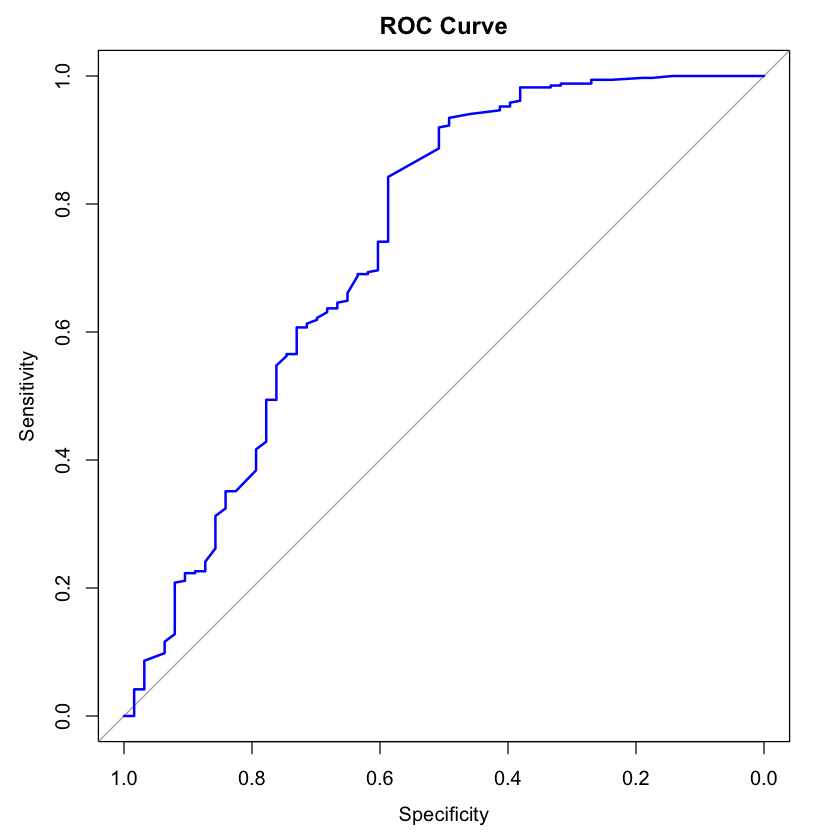

In [445]:
library(caret)
library(pROC)

logistic_model <- glm(D1A_1V1L ~ ., data = train, family = binomial)

predictions <- predict(logistic_model, newdata = test, type = "response")

binary_predictions <- ifelse(predictions >= 0.5, 1, 0)

confusion_matrix <- confusionMatrix(factor(binary_predictions), test$D1A_1V1L)

accuracy <- confusion_matrix$overall["Accuracy"]


specificity <- confusion_matrix$table[2, 2] / (confusion_matrix$table[2, 2] + confusion_matrix$table[2, 1])


recall <- confusion_matrix$table[1, 1] / (confusion_matrix$table[1, 1] + confusion_matrix$table[2, 1])


sensitivity <- confusion_matrix$table[1, 1] / (confusion_matrix$table[1, 1] + confusion_matrix$table[1, 2])


roc <- roc(test$D1A_1V1L, predictions)
auc <- auc(roc)


plot(roc, main = "ROC Curve", col = "blue", lwd = 2)

metrics_df <- data.frame(
  Accuracy = accuracy,
  Specificity = specificity,
  Recall = recall,
  Sensitivity = sensitivity,
  AUC = auc
)

# Print metrics
print(metrics_df)


# Logistic Regression with CV

In [446]:
unique(train$D1A_1V1L)

[1] 99999 0     1    
Levels: 0 1 99999

In [447]:
num_rows <- nrow(train)
num_rows

[1] 18806

In [448]:
train <- train[train$D1A_1V1L %in% c(0, 1), ]
test <- test[test$D1A_1V1L %in% c(0, 1), ]



In [449]:
train$D1A_1V1L <- as.character(train$D1A_1V1L)
unique_values <- unique(train$D1A_1V1L)
print(unique_values)


[1] "0" "1"


In [450]:
test$D1A_1V1L <- as.character(test$D1A_1V1L)
unique_values <- unique(test$D1A_1V1L)
print(unique_values)


[1] "0" "1"


In [451]:
num_rows <- nrow(train)
num_rows

[1] 1601

In [452]:
library(glmnet)
logistic_model <- glmnet(as.matrix(train[, -1]), train$D1A_1V1L, family = "binomial")
cv <- cv.glmnet(as.matrix(train[, -1]), train$D1A_1V1L, family = "binomial", nfolds = 5)
print(cv)
plot(cv)

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numeri

ERROR: Error in predict.train(logistic_model, newdata = test, type = "response"): type must be either "raw" or "prob"


In [ ]:
# Load required libraries
library(caret)
library(pROC)

# Define the control parameters for cross-validation
ctrl <- trainControl(method = "cv",   # Use cross-validation
                     number = 10)     # 10-fold cross-validation

# Train the logistic regression model with cross-validation
logistic_model <- train(D1A_1V1L ~ .,             # Formula specifying the model
                        data = train,            # Training data
                        method = "glm",         # Specify glm method
                        trControl = ctrl,       # Cross-validation control
                        family = binomial)      # Binomial family for logistic regression

# Make predictions on the test set
predictions <- predict(logistic_model, newdata = test)

# Evaluate the model performance
performance <- roc(test$D1A_1V1L, predictions)



Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorithm did not converge"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm

ERROR: Error in roc.default(test$D1A_1V1L, predictions): Predictor must be numeric or ordered.


In [ ]:
# Random Forest 

In [ ]:
# Load required libraries
library(caret)

# Define the control parameters for cross-validation
ctrl <- trainControl(method = "cv",   # Use cross-validation
                     number = 10)     # 10-fold cross-validation

# Train the Random Forest model with cross-validation
rf_model <- train(D1A_1V1L ~ .,             # Formula specifying the model
                  data = train,            # Training data
                  method = "rf",           # Random Forest method
                  trControl = ctrl)       # Cross-validation control

# View the summary of the trained model
summary(rf_model)

# Ensure predicted values have the same levels as actual values
predictions <- factor(predictions, levels = levels(test$D1A_1V1L))

# Evaluate the model performance
confusionMatrix(predictions, test$D1A_1V1L)



                Length Class      Mode     
call               4   -none-     call     
type               1   -none-     character
predicted       1601   factor     numeric  
err.rate        1500   -none-     numeric  
confusion          6   -none-     numeric  
votes           3202   matrix     numeric  
oob.times       1601   -none-     numeric  
classes            2   -none-     character
importance        52   -none-     numeric  
importanceSD       0   -none-     NULL     
localImportance    0   -none-     NULL     
proximity          0   -none-     NULL     
ntree              1   -none-     numeric  
mtry               1   -none-     numeric  
forest            14   -none-     list     
y               1601   factor     numeric  
test               0   -none-     NULL     
inbag              0   -none-     NULL     
xNames            52   -none-     character
problemType        1   -none-     character
tuneValue          1   data.frame list     
obsLevels          2   -none-   

ERROR: Error: `data` and `reference` should be factors with the same levels.
